### Assignment 3: EDA and Prediction with Logistic Regression 

### You must push a version before next Thursday at class time! 

### The Heart Disease Prediction dataset provides vital insight in the relationship between risk factors and cardiac health. This dataset contains 270 case studies of individuals classified as either having or not having heart disease based on results from cardiac catheterizations - the gold standard in heart health assessment. Each patient is identified by 13 independent predictive variables revealing their age, sex, chest pain type, blood pressure measurements, cholesterol levels, electrocardiogram results, exercise-induced angina symptoms, and the number of vessels seen on fluoroscopy showing narrowing of their coronary arteries

In [94]:
import pandas as pd  
heart = pd.read_csv('Heart.csv')
import numpy as np


from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder



### 2. Use pandas method to summarize the properties of the data. Use `head` and `info` and `.value_counts` and `describe` pandas methods to explore the data. 
### Identify which variables are categorical, and which variables are numeric.For categorical data, use `.value_counts` to identify any variables that are highly imbalanced.  
### Are there any missing data? 
### What is the primary target variable (i.e., variable to predict).  Are there any interesting secondary variables to predict? 
### After your exploration, write a few sentences in a markdown box to comment on these questions.  

In [95]:

path = 'heart.csv' 
print(heart.columns)
print("\nHead of the dataset:")
print(heart.head())
print("\nInformation about the dataset:")
print(heart.info())
print("\nMissing data:")
print(heart.isnull().sum())
categorical_variables = ['Sex', 'ChestPain', 'Fbs', 'RestECG', 'ExAng', 'Slope', 'Thal', 'AHD']
print("\nValue counts for categorical variables:")
for var in categorical_variables:
    try:
        print(f"\n{var}:")
        print(heart[var].value_counts())
    except KeyError as e:
        print(f"Error: {e}. Check if the column name '{var}' exists in the dataset.")

print("\nDescription of numeric variables:")
print(heart.describe())
target= 'AHD' 
print("\nPrimary target variable:")
print(f"{target}:")
print(heart[target].value_counts())



Index(['Unnamed: 0', 'Age', 'Sex', 'ChestPain', 'RestBP', 'Chol', 'Fbs',
       'RestECG', 'MaxHR', 'ExAng', 'Oldpeak', 'Slope', 'Ca', 'Thal', 'AHD'],
      dtype='object')

Head of the dataset:
   Unnamed: 0  Age  Sex     ChestPain  RestBP  Chol  Fbs  RestECG  MaxHR  \
0           1   63    1       typical     145   233    1        2    150   
1           2   67    1  asymptomatic     160   286    0        2    108   
2           3   67    1  asymptomatic     120   229    0        2    129   
3           4   37    1    nonanginal     130   250    0        0    187   
4           5   41    0    nontypical     130   204    0        2    172   

   ExAng  Oldpeak  Slope   Ca        Thal  AHD  
0      0      2.3      3  0.0       fixed   No  
1      1      1.5      2  3.0      normal  Yes  
2      1      2.6      2  2.0  reversable  Yes  
3      0      3.5      3  0.0      normal   No  
4      0      1.4      1  0.0      normal   No  

Information about the dataset:
<class 'pandas.core.fr

### 2.  Use Seaborn to explore the numeric data graphically. Two goals here. First, are there any variables that are highly correlated with each other.  Second, are there any variables that seem likely to be helpful in building a model that can predict heart disease. Write your hypothesis in the markdown box provided.  

/var/folders/h2/vw816z697sd8jry1l3t7x1xc0000gn/T/ipykernel_93892/3778176488.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = heart.corr()


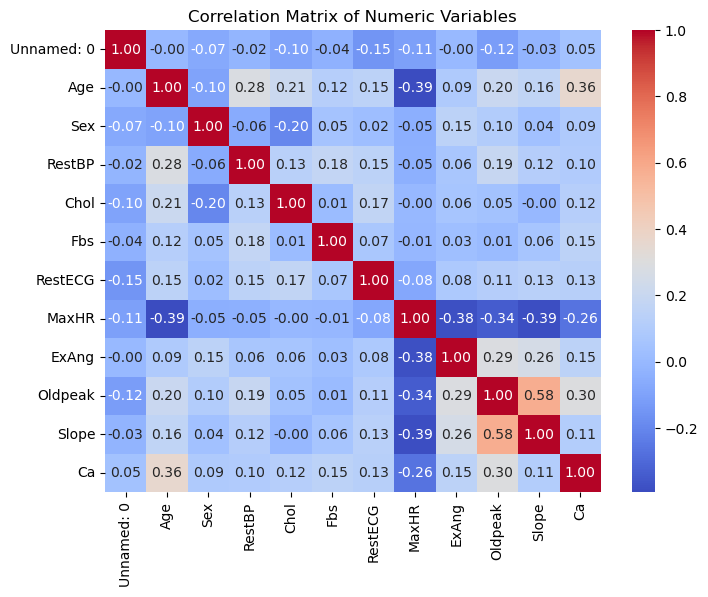

In [96]:

import seaborn as sns
import matplotlib.pyplot as plt

correlation = heart.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Variables')
plt.show()


### 3. As the analysis plan is to use a Logistic Regression model, all variables will need to be converted to numeric representations. One way to do this is `pd.get_dummies` which I give an example below. The other way to do it is to use .map method and define an encoder. 

### I show both approaches below.  Typically, if there is an obvious hierarchical relationship, I might use my own encoder to express that.  If there isnt, get_dummies is more sensible then a hierarchical approach

### After you encode the heart data, feel free to delete my example code.  

In [97]:

heart = pd.read_csv('heart.csv')

heart_encoded_get_dummies = pd.get_dummies(heart, columns=['Sex', 'ChestPain', 'Thal'], drop_first=True)

chest_pain_encoder = {'nonanginal': 1, 'nontypical': 2, 'typical': 3}
heart['ChestPain_Hierarchical'] = heart['ChestPain'].map(chest_pain_encoder)
print("Encoded with pd.get_dummies:")
print(heart_encoded_get_dummies.head())

print("\nEncoded with custom hierarchical encoder:")
print(heart[['Sex', 'ChestPain', 'Thal', 'ChestPain_Hierarchical']].head())



Encoded with pd.get_dummies:
   Unnamed: 0  Age  RestBP  Chol  Fbs  RestECG  MaxHR  ExAng  Oldpeak  Slope  \
0           1   63     145   233    1        2    150      0      2.3      3   
1           2   67     160   286    0        2    108      1      1.5      2   
2           3   67     120   229    0        2    129      1      2.6      2   
3           4   37     130   250    0        0    187      0      3.5      3   
4           5   41     130   204    0        2    172      0      1.4      1   

    Ca  AHD  Sex_1  ChestPain_nonanginal  ChestPain_nontypical  \
0  0.0   No      1                     0                     0   
1  3.0  Yes      1                     0                     0   
2  2.0  Yes      1                     0                     0   
3  0.0   No      1                     1                     0   
4  0.0   No      0                     0                     1   

   ChestPain_typical  Thal_normal  Thal_reversable  
0                  1            0       

### 4. We are going to have to decide how we want to cross-validate the models we build. First split the data into training and test data (using `train_test_split`). I recommend 25% test set data.   Then using the training data only, make use of K-fold cross validation to create multiple training and test sets. I recommend doing 5-folds.    

In [98]:
from sklearn.model_selection import train_test_split, KFold

X = heart.drop('AHD', axis=1)
y = heart['AHD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



X_train shape: (227, 15)
X_test shape: (76, 15)
y_train shape: (227,)
y_test shape: (76,)


### 5. Fit a logistic regression model on the training data using K-fold cross-validation to first assess model fit. Your assessment should include accuracy, confusion matrix, and ROC curve.     

/Users/amytu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/amytu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

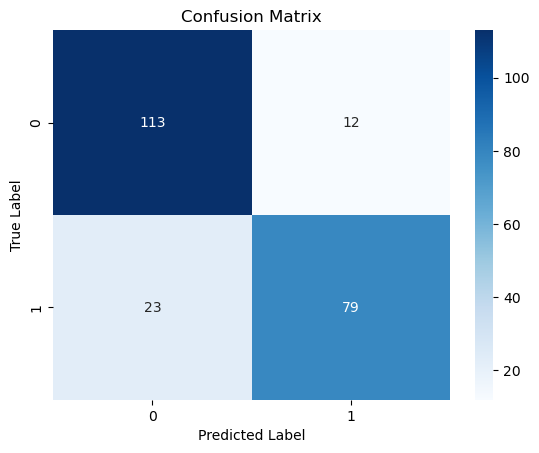

0.8458149779735683

In [99]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

numeric_features = X_train.select_dtypes(include=['number']).columns
categorical_features = X_train.select_dtypes(exclude=['number']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression())])

ycv = cross_val_predict(pipeline, X_train, y_train_encoded, cv=5)

# Assess model fit
accuracy = accuracy_score(y_train_encoded, ycv)
conf_matrix = confusion_matrix(y_train_encoded, ycv)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Output the accuracy
accuracy

    

### 6. Fit a logistic regression model using all the training data and test it on the test data.  Provide accuracy, confusion matrix, and ROC curve.

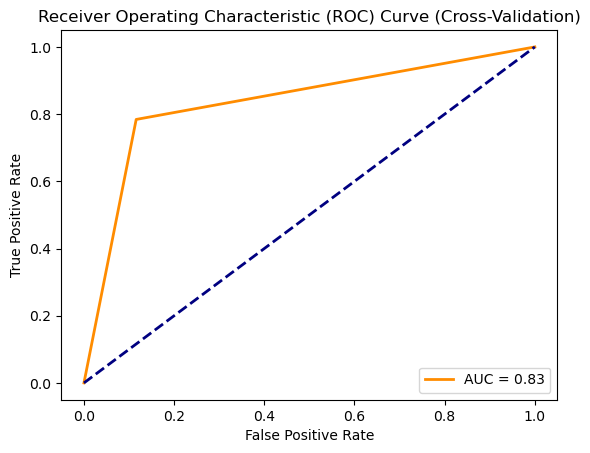

Accuracy (Cross-Validation): 83.83%


In [100]:

labelencoder = LabelEncoder()
yencode = labelencoder.fit_transform(y)

numericfeatures = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(exclude=['number']).columns

numerictransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # Add StandardScaler for numeric features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerictransformer, numericfeatures),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression())])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ycv = cross_val_predict(pipeline, X, yencode, cv=kf)

accuracy_cv = accuracy_score(yencode, ycv)
conf_matrix_cv = confusion_matrix(yencode, ycv)

fpr_cv, tpr_cv, thresholds_cv = roc_curve(yencode, ycv)
roc_auc_cv = auc(fpr_cv, tpr_cv)

plt.figure()
plt.plot(fpr_cv, tpr_cv, color='darkorange', lw=2, label=f'AUC = {roc_auc_cv:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Cross-Validation)')
plt.legend(loc="lower right")
plt.show()

print(f"Accuracy (Cross-Validation): {accuracy_cv:.2%}")



### 7.Examine your model to determine if you can understand what features and criterion it is using to classify the data. Write your descriptive answer in the markdown box.   

In [101]:

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_imputed, y_encoded)

names = X.columns
coeff = logreg.coef_[0]

print(f"Number of features: {len(names)}")
print(f"Number of coefficients: {len(coeff)}")

print("Feature:", names)
print("Coefficients:", coeff)



Number of features: 15
Number of coefficients: 19
Feature: Index(['Unnamed: 0', 'Age', 'Sex', 'ChestPain', 'RestBP', 'Chol', 'Fbs',
       'RestECG', 'MaxHR', 'ExAng', 'Oldpeak', 'Slope', 'Ca', 'Thal',
       'ChestPain_Hierarchical'],
      dtype='object')
Coefficients: [ 0.00170063 -0.02380025  0.01784365  0.00388405 -0.28267966 -0.02219277
  0.72851872  0.40916955  1.11759997  1.01615752 -1.29654634 -0.64240423
 -1.22113966  0.12553129  0.44784768  0.68991257  0.11720532 -0.57310161
  0.85418771]


/Users/amytu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
